In [78]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import MinMaxScaler
import pandas as pd

In [79]:
class ImageStatistics:
    """
    A class to compute and analyze statistical properties of image datasets.
    """
    
    @staticmethod
    def minmax_normalize(img):
        """Normalize image to [0, 1] range using min-max scaling."""
        scaler = MinMaxScaler()
        img_flat = img.reshape(-1, 1)
        normalized_flat = scaler.fit_transform(img_flat)
        return normalized_flat.reshape(img.shape)
    
    @staticmethod
    def compute_image_moments(img):
        """Compute spatial moments of an image."""
        H, W = img.shape
        yy, xx = np.mgrid[0:H, 0:W]
        m00 = img.sum() + 1e-12
        cx = (xx * img).sum() / m00
        cy = (yy * img).sum() / m00
        x_c = xx - cx
        y_c = yy - cy
        mu20 = (x_c * x_c * img).sum() / m00
        mu11 = (x_c * y_c * img).sum() / m00
        return cx, cy, mu20, mu11
    
    @classmethod
    def extract_features(cls, images):
        """Extract statistical features from a batch of images."""
        means, centroid_distances, skewness = [], [], []
        
        for img in images:
            normalized_img = cls.minmax_normalize(img)
            means.append(float(normalized_img.mean()))
            cx, cy, mu20, mu11 = cls.compute_image_moments(normalized_img)
            centroid_distances.append(float(np.hypot(cx - 14, cy - 14)))
            skewness.append(float(mu11 / (mu20 + 1e-12)))
        
        return np.array(means), np.array(centroid_distances), np.array(skewness)
    
    @staticmethod
    def plot_comparative_histograms(std_features, mod_features, feature_names, title="Comparative Analysis"):
        """Plot comparative histograms for multiple features."""
        n_features = len(feature_names)
        fig, axes = plt.subplots(1, n_features, figsize=(5 * n_features, 4))
        
        if n_features == 1:
            axes = [axes]
        
        for i, (std_feat, mod_feat, name) in enumerate(zip(std_features, mod_features, feature_names)):
            axes[i].hist(std_feat, bins=30, alpha=0.6, label="Standard", density=True, color='blue')
            axes[i].hist(mod_feat, bins=30, alpha=0.6, label="Modified", density=True, color='orange')
            axes[i].set_title(name)
            axes[i].legend()
            axes[i].grid(True, alpha=0.3)
        
        plt.suptitle(title, fontsize=14)
        plt.tight_layout()
        plt.show()
    
    @staticmethod
    def create_summary_dataframe(std_features, mod_features, feature_names):
        """Create a summary DataFrame with mean and std for each feature."""
        metrics = []
        standard_values = []
        modified_values = []
        
        for std_feat, mod_feat, name in zip(std_features, mod_features, feature_names):
            metrics.extend([f"{name}_mean", f"{name}_std"])
            standard_values.extend([std_feat.mean(), std_feat.std()])
            modified_values.extend([mod_feat.mean(), mod_feat.std()])
        
        return pd.DataFrame({
            "metric": metrics,
            "standard": standard_values,
            "modified": modified_values
        })

In [80]:
class MNISTDataLoader:
    """
    A class to handle MNIST data loading, visualization, and qualitative diagnostics.
    """
    
    def __init__(self, target_digits=[1, 4, 7, 9]):
        self.target_digits = target_digits
        self.X = None
        self.y = None
        self.X_std = None
        self.y_std = None
    
    def load_data(self, file_path_modified='Dataset/Q7/X_modified.npy', file_path_true='Dataset/Q7/y_true.npy'):
        """Load both modified and standard MNIST data."""
        self.X = np.load(file_path_modified)
        self.y = np.load(file_path_true)
        X_mnist, y_mnist = fetch_openml('mnist_784', version=1, return_X_y=True, as_frame=False, parser='auto')
        X_mnist = X_mnist.reshape(-1, 28, 28).astype("float32") / 255.0
        y_mnist = y_mnist.astype(int)
        mask = np.isin(y_mnist, self.target_digits)
        self.X_std = X_mnist[mask]
        self.y_std = y_mnist[mask]
        return self.X, self.y, self.X_std, self.y_std

    def plot_comparison(self, n_samples=5):
        """Plot comparison between standard and modified MNIST digits."""
        if self.X is None or self.X_std is None:
            raise ValueError("Data not loaded. Call load_data() first.")
        
        digits_present = np.unique(self.y)  
        rows = len(digits_present) * 2    
        cols = n_samples
        fig, axes = plt.subplots(rows, cols, figsize=(10, 8))
        
        for r, digit in enumerate(digits_present):
            std_idx = np.where(self.y_std == digit)[0][:n_samples]
            mod_idx = np.where(self.y == digit)[0][:n_samples]
            
            for c in range(n_samples):
                ax_std = axes[2*r, c]
                ax_mod = axes[2*r+1, c]
                ax_std.imshow(self.X_std[std_idx[c]], cmap="gray")
                ax_mod.imshow(self.X[mod_idx[c]], cmap="gray")
                ax_std.set_xticks([]); ax_std.set_yticks([])
                ax_mod.set_xticks([]); ax_mod.set_yticks([])
                
                if c == 0:
                    ax_std.set_ylabel(f"{digit} (std)", fontsize=10)
                    ax_mod.set_ylabel(f"{digit} (mod)", fontsize=10)
                if r == 0:
                    ax_std.set_title(f"Sample {c+1}", fontsize=10)

        plt.suptitle("Standard vs Modified MNIST — Labeled Comparison (Digits 1, 4, 7, 9)", fontsize=14)
        plt.tight_layout()
        plt.show()

    def perform_qualitative_diagnostics(self, save_csv=False, csv_filename="mnist_comparative_summary.csv"):
        """Statistical comparitive analysis between modified and standard MNIST"""
        if self.X is None or self.X_std is None:
            raise ValueError("Data not loaded. Call load_data() first.")
        
        stats = ImageStatistics()
        std_means, std_cd, std_skews = stats.extract_features(self.X_std)
        mod_means, mod_cd, mod_skews = stats.extract_features(self.X)

        feature_names = ["Mean Intensity", "Centroid Distance", "Skew (mu11/mu20)"]
        stats.plot_comparative_histograms(
            [std_means, std_cd, std_skews],
            [mod_means, mod_cd, mod_skews],
            feature_names,
            "Comparative Diagnostics — Standard vs Modified (Digits 1,4,7,9)"
        )
        
        summary = stats.create_summary_dataframe(
            [std_means, std_cd, std_skews],
            [mod_means, mod_cd, mod_skews],
            ["mean_intensity", "centroid_dist", "skew"]
        )
        
        print("Statistical Summary:")
        print(summary.round(4))

        if save_csv:
            summary.to_csv(csv_filename, index=False)
            print(f"Summary saved to: {csv_filename}")
        
        return summary
    
    def get_data(self):
        """Get the loaded data."""
        if self.X is None:
            raise ValueError("Data not loaded. Call load_data() first.")
        return self.X, self.y, self.X_std, self.y_std


In [81]:
class KMeans:
    """
    Our custom K-Means clustering implementation.
    """
    def __init__(self, k, max_iters=100, random_state=42):
        self.k = k
        self.max_iters = max_iters
        self.random_state = random_state
        self.centroids = None
        self.cost = None
        self.labels_ = None 

    def _euclidean_distance(self, point1, point2):
        """Calculates the squared Euclidean distance between two points."""
        return np.sum((point1 - point2)**2)

    def fit(self, X):
        """Fits the K-Means model to the data."""
        n_samples, n_features = X.shape
        np.random.seed(self.random_state)
        random_indices = np.random.choice(n_samples, self.k, replace=False)
        self.centroids = X[random_indices]

        for _ in range(self.max_iters):
            clusters = [[] for _ in range(self.k)]
            for point in X:
                distances = [self._euclidean_distance(point, centroid) for centroid in self.centroids]
                closest_centroid_idx = np.argmin(distances)
                clusters[closest_centroid_idx].append(point)
            old_centroids = self.centroids.copy()
            for i in range(self.k):
                if clusters[i]:
                    self.centroids[i] = np.mean(clusters[i], axis=0)
            if np.all(self.centroids == old_centroids):
                break
        
        self.labels_ = self.predict(X)
        self._calculate_cost(X)

    def predict(self, X):
        """Assigns each data point to the nearest centroid."""
        if self.centroids is None:
            raise RuntimeError("Model has not been fitted yet.")
        
        labels = []
        for point in X:
            distances = [self._euclidean_distance(point, centroid) for centroid in self.centroids]
            closest_centroid_idx = np.argmin(distances)
            labels.append(closest_centroid_idx)
        return np.array(labels)

    def _calculate_cost(self, X):
        """Calculates the total cost (WCSS) of the clustering."""
        self.cost = 0
        for i, point in enumerate(X):
            assigned_centroid = self.centroids[self.labels_[i]]
            self.cost += self._euclidean_distance(point, assigned_centroid)

    def getCost(self):
        """Returns the total cost (WCSS) of the clustering."""
        if self.cost is None:
            raise RuntimeError("Cost is not available.")
        return self.cost

In [82]:
class CustomPCA:
    """A custom implementation of Principal Component Analysis (PCA)."""
    def __init__(self, n_components):
        self.n_components = n_components
        self.components = None  
        self.mean = None
        self.explained_variance_ratio_ = None

    def fit(self, X):
        """Fits the PCA model to the data X."""
        self.mean = np.mean(X, axis=0)
        X_centered = X - self.mean
        cov_matrix = np.cov(X_centered, rowvar=False)
        eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)
        sorted_indices = np.argsort(eigenvalues)[::-1]
        sorted_eigenvalues = eigenvalues[sorted_indices]
        sorted_eigenvectors = eigenvectors[:, sorted_indices]
        self.components = sorted_eigenvectors[:, :self.n_components]
        total_variance = np.sum(sorted_eigenvalues)
        self.explained_variance_ratio_ = sorted_eigenvalues / total_variance

    def transform(self, X):
        """Projects the data X onto the principal components."""
        X_centered = X - self.mean
        return X_centered @ self.components

    def inverse_transform(self, X_transformed):
        """Reconstructs the original data from the transformed data."""
        return (X_transformed @ self.components.T) + self.mean

    def checkPCA(self):
        """Checks the PCA implementation for correctness."""
        dummy_data = np.random.rand(5, 10)
        self.fit(dummy_data)
        transformed_data = self.transform(dummy_data)
        expected_shape = (5, self.n_components)
        actual_shape = transformed_data.shape
        if actual_shape != expected_shape:
            return False
        reconstructed = self.inverse_transform(transformed_data)
        if reconstructed.shape != dummy_data.shape:
            return False
        return True
            

In [83]:
class ClusteringMetrics:
    """
    A class to compute clustering evaluation metrics.
    """
    
    @staticmethod
    def _contingency(gt, pr):
        """Compute the contingency table between ground truth and predicted labels."""
        cls = np.unique(gt)
        clu = np.unique(pr)
        tab = np.zeros((cls.size, clu.size), dtype=np.int64)
        for i, c in enumerate(cls):
            m = (gt == c)
            for j, k in enumerate(clu):
                tab[i, j] = np.sum(pr[m] == k)
        return tab

    @classmethod
    def nmi_score(cls, gt, pr):
        """Compute the Normalized Mutual Information (NMI) score."""
        C = cls._contingency(gt, pr).astype(np.float64)
        n = C.sum()
        if n == 0: 
            return 0.0
        pi = C.sum(1) / n
        pj = C.sum(0) / n
        Pij = C / n
        nz = Pij > 0
        denom = np.where((pi[:, None] * pj[None, :]) == 0, 1e-12, pi[:, None] * pj[None, :])
        I = (Pij[nz] * np.log(Pij[nz] / denom[nz])).sum()
        Hc = -(pi[pi > 0] * np.log(pi[pi > 0])).sum()
        Hk = -(pj[pj > 0] * np.log(pj[pj > 0])).sum()
        return float(I / (0.5 * (Hc + Hk) + 1e-12))

    @classmethod
    def ari_score(cls, gt, pr):
        """Compute the Adjusted Rand Index (ARI) score."""
        C = cls._contingency(gt, pr).astype(np.int64)
        n = C.sum()
        nij = C
        sum_nij2 = (nij * (nij - 1)).sum() / 2.0
        ai = nij.sum(1)
        bj = nij.sum(0)
        sum_ai2 = (ai * (ai - 1)).sum() / 2.0
        sum_bj2 = (bj * (bj - 1)).sum() / 2.0
        denom = (n * (n - 1)) / 2.0
        expected = (sum_ai2 * sum_bj2) / (denom + 1e-12)
        max_index = 0.5 * (sum_ai2 + sum_bj2)
        return float((sum_nij2 - expected) / (max_index - expected + 1e-12))
    
    @classmethod
    def evaluate(cls, y_true, y_pred):
        """Compute both NMI and ARI scores."""
        return {
            "NMI": cls.nmi_score(y_true, y_pred),
            "ARI": cls.ari_score(y_true, y_pred)
        }

In [84]:
class DigitCanonicalizer:
    def __init__(self,
                 do_centering=True,
                 do_rotate=True,
                 do_upright=True,
                 on_resize=True,
                 target_len=20,
                 canvas_len=28,
                 do_standardize=True,
                 thresh_val=20):
        self.do_centering = do_centering
        self.do_rotate = do_rotate
        self.do_upright = do_upright
        self.on_resize = on_resize
        self.target_len = target_len
        self.canvas_len = canvas_len
        self.do_standardize = do_standardize
        self.thresh_val = thresh_val

    @staticmethod
    def _minmax01(arr):
        if arr.max() == arr.min():
            return np.zeros_like(arr)
        scaler = MinMaxScaler()
        arr_flat = arr.reshape(-1, 1)
        normalized_flat = scaler.fit_transform(arr_flat)
        return normalized_flat.reshape(arr.shape)

    def _active_coords(self, img):
        return np.where(img > self.thresh_val)

    def _center_of_mass(self, img):
        ys, xs = self._active_coords(img)
        if xs.size == 0:
            h, w = img.shape
            return float(h // 2), float(w // 2)
        return float(ys.mean()), float(xs.mean())

    def _shift_to_center(self, img, cy, cx):
        h, w = img.shape
        dy = int(h // 2 - cy)
        dx = int(w // 2 - cx)
        out = np.zeros_like(img)
        ys, xs = np.nonzero(img)
        ny, nx = ys + dy, xs + dx
        m = (ny >= 0) & (ny < h) & (nx >= 0) & (nx < w)
        out[ny[m], nx[m]] = img[ys[m], xs[m]]
        return out

    @staticmethod
    def _pca_angle(img, thresh):
        ys, xs = np.where(img > thresh)
        if xs.size < 2:
            return 0.0
        coords = np.stack([xs, ys], 1).astype(np.float64)
        coords -= coords.mean(0, keepdims=True)
        cov = np.cov(coords, rowvar=False)
        w, V = np.linalg.eigh(cov)
        main = V[:, np.argmax(w)]
        return float(np.arctan2(main[1], main[0]))

    @staticmethod
    def _rotate_nn(img, angle_rad):
        h, w = img.shape
        cy, cx = h // 2, w // 2
        out = np.zeros_like(img)
        ca, sa = np.cos(angle_rad), np.sin(angle_rad)
        for yd in range(h):
            for xd in range(w):
                yy = yd - cy
                xx = xd - cx
                xs = ca * xx + sa * yy + cx
                ys = -sa * xx + ca * yy + cy
                xs_i, ys_i = int(round(xs)), int(round(ys))
                if 0 <= xs_i < w and 0 <= ys_i < h:
                    out[yd, xd] = img[ys_i, xs_i]
        return out

    def _tight_resize_to_canvas(self, img):
        img01 = self._minmax01(img)
        hist, _ = np.histogram(img01.ravel(), bins=256, range=(0, 1))
        p = hist.astype(np.float64) / img01.size
        w0 = np.cumsum(p); w1 = 1 - w0
        bins = (np.arange(256) + 0.5) / 256.0
        mu = np.cumsum(p * bins); mu_t = mu[-1]
        bcvar = np.zeros_like(w0); nz = (w0 * w1) > 0
        bcvar[nz] = ((mu_t * w0[nz] - mu[nz]) ** 2) / (w0[nz] * w1[nz])
        t = (np.argmax(bcvar) + 0.5) / 256.0
        mask = (img01 > t).astype(np.uint8)
        ys, xs = np.where(mask > 0)
        if xs.size == 0:
            return img
        y0, y1 = ys.min(), ys.max()
        x0, x1 = xs.min(), xs.max()
        crop = img[y0:y1 + 1, x0:x1 + 1]
        h, w = crop.shape
        if h >= w:
            new_h = self.target_len
            new_w = max(1, int(round(w * self.target_len / h)))
        else:
            new_w = self.target_len
            new_h = max(1, int(round(h * self.target_len / w)))
        yy, xx = np.mgrid[0:new_h, 0:new_w]
        yy_src = np.clip((yy * (h / new_h)).round().astype(int), 0, h - 1)
        xx_src = np.clip((xx * (w / new_w)).round().astype(int), 0, w - 1)
        small = crop[yy_src, xx_src]
        out = np.zeros((self.canvas_len, self.canvas_len), dtype=img.dtype)
        yoff = (self.canvas_len - new_h) // 2
        xoff = (self.canvas_len - new_w) // 2
        out[yoff:yoff + new_h, xoff:xoff + new_w] = small
        return out

    @staticmethod
    def _std_clip01(img):
        mu = float(img.mean())
        sd = float(img.std()) + 1e-6
        z = np.clip((img - mu) / sd, -2, 2)
        z -= z.min()
        z /= (z.max() + 1e-12)
        return z

    def normalize_one(self, img):
        work = img.copy()
        if self.do_centering:
            cy, cx = self._center_of_mass(work)
            work = self._shift_to_center(work, cy, cx)
        if self.do_rotate:
            theta = self._pca_angle(work, self.thresh_val)
            corr = -(theta - np.pi / 2.0)
            work = self._rotate_nn(work, corr)
        if self.do_upright:
            ys, _ = self._active_coords(work)
            if ys.size > 2:
                y0 = ys - ys.mean()
                m3 = float(np.mean(y0 ** 3))
                if m3 < 0:
                    work = self._rotate_nn(work, np.pi)
        if self.on_resize:
            work = self._tight_resize_to_canvas(work)
        if self.do_standardize:
            work = self._std_clip01(work)
        return work

    def normalize_batch(self, imgs):
        return np.stack([self.normalize_one(im) for im in imgs], axis=0)

    def features_batch(self, imgs):
        ims = self.normalize_batch(imgs)
        feats = ims.reshape(len(ims), -1).astype(np.float32)
        return ims, feats

In [85]:
class ClusterWorkbench:
    def __init__(self, canonizer: DigitCanonicalizer, pca_model, kmeans_model):
        self.canonizer = canonizer
        self.pca_model = pca_model
        self.kmeans_model = kmeans_model
        self.labels_ = None
        self.embedded_ = None
        self.features_ = None
        self.images_ = None

    def run(self, X28, n_components=40, fit_pca=True):
        imgs, feats = self.canonizer.features_batch(X28)
        self.images_ = imgs
        self.features_ = feats

        if fit_pca:
            self.pca_model.fit(feats)
        Z = self.pca_model.transform(feats)
        self.embedded_ = Z

        self.kmeans_model.fit(Z)
        self.labels_ = self.kmeans_model.labels_
        return self.labels_

    @staticmethod
    def evaluate(y_true, y_pred):
        return ClusteringMetrics.evaluate(y_true, y_pred)

    def show_pairs(self, X28, n_cols=8):
        """Show original vs normalized pairs."""
        idxs = np.linspace(0, len(X28) - 1, n_cols, dtype=int)
        normed, _ = self.canonizer.features_batch(X28[idxs])
        fig, ax = plt.subplots(2, len(idxs), figsize=(1.4 * n_cols, 3.6))
        for i, idx in enumerate(idxs):
            ax[0, i].imshow(X28[idx], cmap='gray'); ax[0, i].axis('off')
            ax[0, i].set_title(f"orig {idx}", fontsize=8)
            ax[1, i].imshow(normed[i], cmap='gray'); ax[1, i].axis('off')
            if i == 0:
                ax[0, i].set_ylabel("Before"); ax[1, i].set_ylabel("After")
        plt.tight_layout(); plt.show()

    def plot_pca_scatter(self, y_true=None, title="PCA (first 2 comps)"):
        """Quick 2D scatter of the first two PCA coords; colored by y_true if given, else by cluster."""
        if self.embedded_ is None:
            raise RuntimeError("Run .run() first.")
        P = self.embedded_
        if P.shape[1] < 2:
            print("Need at least 2 PCA components to plot.")
            return
        c = y_true if y_true is not None else self.labels_
        plt.figure(figsize=(5.4, 4.6))
        plt.scatter(P[:, 0], P[:, 1], c=c, s=10, alpha=0.8)
        plt.title(title); plt.xlabel("PC1"); plt.ylabel("PC2")
        plt.tight_layout()
        plt.show()

In [86]:
class ClusteringExperimentRunner:
    """
    A comprehensive class to run and evaluate different clustering experiments.
    """
    
    def __init__(self, X, y, n_components=40, k=4, max_iters=200, random_state=0):
        self.X = X
        self.y = y
        self.n_components = n_components
        self.k = k
        self.max_iters = max_iters
        self.random_state = random_state
        self.results = []
        self.workbenches = {}
        
    def run_experiment(self, name, canonizer_config):
        """Run a single clustering experiment."""
        pca_model = CustomPCA(n_components=self.n_components)
        kmeans_model = KMeans(k=self.k, max_iters=self.max_iters, random_state=self.random_state)
        canonizer = DigitCanonicalizer(**canonizer_config)
        workbench = ClusterWorkbench(canonizer, pca_model, kmeans_model)
        labels = workbench.run(self.X, fit_pca=True)
        metrics = workbench.evaluate(self.y, labels)
        result = {
            'Experiment': name,
            'NMI': round(metrics['NMI'], 4),
            'ARI': round(metrics['ARI'], 4),
            'WCSS': round(kmeans_model.getCost(), 2)
        }
        self.results.append(result)
        self.workbenches[name] = workbench
        return workbench, labels
    
    def run_all_experiments(self):
        """Run all predefined clustering experiments."""        
        experiments = [
            ("Raw Pixels", {
                'do_centering': False,
                'do_rotate': False,
                'do_upright': False,
                'on_resize': False,
                'do_standardize': False
            }),
            ("Center of Mass", {
                'do_centering': True,
                'do_rotate': False,
                'do_upright': False,
                'on_resize': False,
                'do_standardize': False
            }),
            ("PCA Rotation", {
                'do_centering': False,
                'do_rotate': True,
                'do_upright': False,
                'on_resize': False,
                'do_standardize': False
            }),
            ("COM + PCA Rotation", {
                'do_centering': True,
                'do_rotate': True,
                'do_upright': False,
                'on_resize': False,
                'do_standardize': False
            }),
            ("Full Canonicalization", {
                'do_centering': True,
                'do_rotate': True,
                'do_upright': True,
                'on_resize': True,
                'do_standardize': True
            })
        ]
        
        for name, config in experiments:
            self.run_experiment(name, config)
        return self.results
    
    def display_results_table(self):
        """Display results in a formatted table."""
        df = pd.DataFrame(self.results)
        df = df[['Experiment', 'NMI', 'ARI', 'WCSS']]

        print(df.to_string(index=False, float_format='%.4f'))
        print("Higher NMI/ARI scores are better | Lower WCSS is better")

        best_nmi = df.loc[df['NMI'].idxmax(), 'Experiment']
        best_ari = df.loc[df['ARI'].idxmax(), 'Experiment']
        best_wcss = df.loc[df['WCSS'].idxmin(), 'Experiment']
        
        print(f"BEST PERFORMERS:")
        print(f"NMI: {best_nmi}")
        print(f"ARI: {best_ari}")
        print(f"WCSS: {best_wcss}")
        return df
    
    def plot_pca_comparison(self, figsize=(20, 12)):
        """Create subplot comparison of all PCA scatter plots."""
        n_experiments = len(self.workbenches)
        cols = 3
        rows = (n_experiments + cols - 1) // cols
        
        fig, axes = plt.subplots(rows, cols, figsize=figsize)
        if rows == 1:
            axes = axes.reshape(1, -1)
        
        for i, (name, workbench) in enumerate(self.workbenches.items()):
            row, col = i // cols, i % cols
            ax = axes[row, col]
            
            if workbench.embedded_ is not None and workbench.embedded_.shape[1] >= 2:
                P = workbench.embedded_
                ax.scatter(P[:, 0], P[:, 1], c=self.y, s=15, alpha=0.7, cmap='tab10')
                ax.set_title(f"{name}\n(NMI: {self.results[i]['NMI']:.3f}, ARI: {self.results[i]['ARI']:.3f})", 
                           fontsize=12, pad=10)
                ax.set_xlabel("PC1")
                ax.set_ylabel("PC2")
                ax.grid(True, alpha=0.3)
            else:
                ax.text(0.5, 0.5, "Insufficient\nPCA Components", 
                       ha='center', va='center', transform=ax.transAxes)
                ax.set_title(name)

        for i in range(n_experiments, rows * cols):
            row, col = i // cols, i % cols
            axes[row, col].set_visible(False)
        
        plt.suptitle("PCA Space Visualization - All Clustering Experiments", fontsize=16, y=0.98)
        plt.tight_layout()
        plt.show()
    
    def plot_metrics_comparison(self):
        """Create bar plots comparing metrics across experiments."""
        df = pd.DataFrame(self.results)
        
        fig, axes = plt.subplots(1, 3, figsize=(18, 6))
        
        bars1 = axes[0].bar(range(len(df)), df['NMI'], color='skyblue', alpha=0.8)
        axes[0].set_title('Normalized Mutual Information (NMI)', fontsize=14)
        axes[0].set_ylabel('NMI Score')
        axes[0].set_xticks(range(len(df)))
        axes[0].set_xticklabels(df['Experiment'], rotation=45, ha='right')
        axes[0].grid(True, alpha=0.3)

        for i, bar in enumerate(bars1):
            height = bar.get_height()
            axes[0].text(bar.get_x() + bar.get_width()/2., height + 0.005,
                        f'{height:.3f}', ha='center', va='bottom', fontsize=10)
        
        bars2 = axes[1].bar(range(len(df)), df['ARI'], color='lightgreen', alpha=0.8)
        axes[1].set_title('Adjusted Rand Index (ARI)', fontsize=14)
        axes[1].set_ylabel('ARI Score')
        axes[1].set_xticks(range(len(df)))
        axes[1].set_xticklabels(df['Experiment'], rotation=45, ha='right')
        axes[1].grid(True, alpha=0.3)

        for i, bar in enumerate(bars2):
            height = bar.get_height()
            axes[1].text(bar.get_x() + bar.get_width()/2., height + 0.005,
                        f'{height:.3f}', ha='center', va='bottom', fontsize=10)

        bars3 = axes[2].bar(range(len(df)), df['WCSS'], color='salmon', alpha=0.8)
        axes[2].set_title('Within-Cluster Sum of Squares (WCSS)', fontsize=14)
        axes[2].set_ylabel('WCSS (Lower is Better)')
        axes[2].set_xticks(range(len(df)))
        axes[2].set_xticklabels(df['Experiment'], rotation=45, ha='right')
        axes[2].grid(True, alpha=0.3)

        for i, bar in enumerate(bars3):
            height = bar.get_height()
            axes[2].text(bar.get_x() + bar.get_width()/2., height + height*0.01,
                        f'{height:.0f}', ha='center', va='bottom', fontsize=10)
        
        plt.suptitle("Clustering Performance Metrics Comparison", fontsize=16)
        plt.tight_layout()
        plt.show()

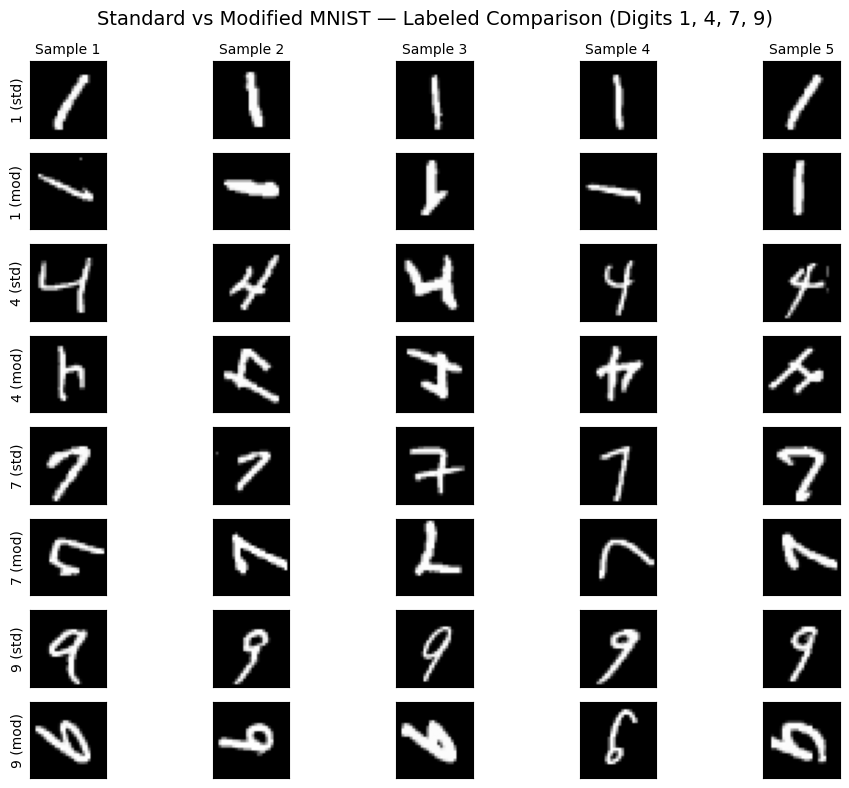

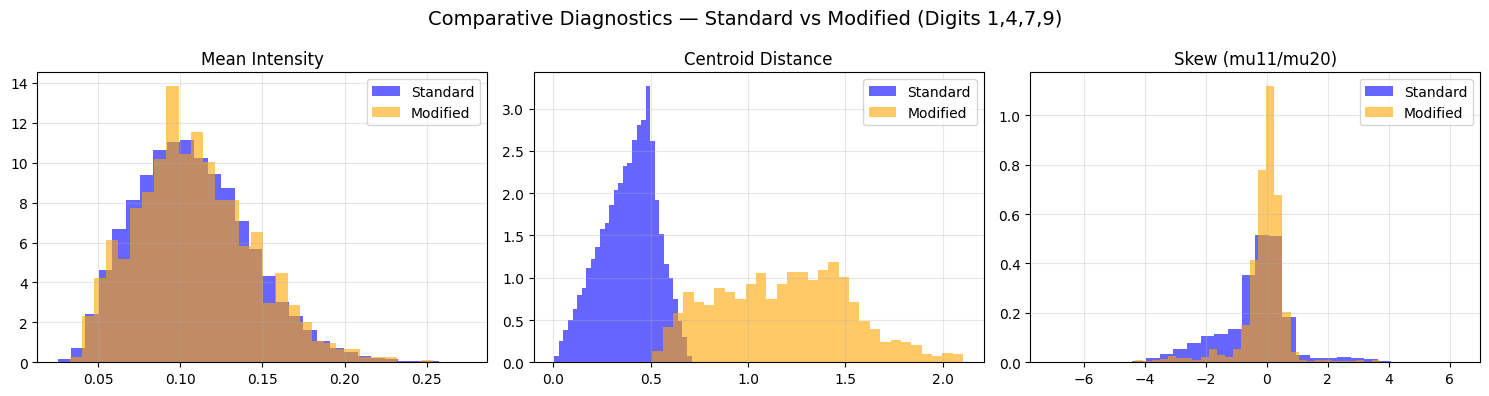

Statistical Summary:
                metric  standard  modified
0  mean_intensity_mean    0.1078    0.1088
1   mean_intensity_std    0.0353    0.0357
2   centroid_dist_mean    0.3875    1.1848
3    centroid_dist_std    0.1416    0.3397
4            skew_mean   -0.3680   -0.0900
5             skew_std    1.1928    0.7631


In [87]:
data_loader = MNISTDataLoader()
X, y, X_std, y_std = data_loader.load_data()
data_loader.plot_comparison()
summary_results = data_loader.perform_qualitative_diagnostics()

## Mean Intensity

- Standard MNIST mean ≈ 0.108 ± 0.035
- Modified MNIST mean ≈ 0.109 ± 0.036
- So intensity distributions are similar
- Polarity is mostly consistent (white digits on black).
- Contrast inversion is not a major issue here.

## Centroid Distance

- Standard MNIST mean ≈ 0.39 px from center
- Modified MNIST mean ≈ 1.18 px from center
- The modified dataset digits are, on average, shifted 3× further from the image center.
- Confirms translation / off-centering is a key alteration.

## Skew

- Standard MNIST mean ≈ –0.37 (broader spread, std ~1.19)
- Modified MNIST mean ≈ –0.09 (narrower spread, std ~0.76)
- The modified digits are less skewed overall, but still show variation.
- Suggests the alteration process may have included some deskewing or consistent tilt adjustment, but not perfect.

           Experiment    NMI    ARI            WCSS
           Raw Pixels 0.1910 0.1408 1910946828.8500
       Center of Mass 0.2016 0.1440 1888528921.1300
         PCA Rotation 0.3493 0.3147 1563672024.0000
   COM + PCA Rotation 0.3529 0.3216 1497208404.8200
Full Canonicalization 0.3835 0.3629      23491.4600
Higher NMI/ARI scores are better | Lower WCSS is better
BEST PERFORMERS:
NMI: Full Canonicalization
ARI: Full Canonicalization
WCSS: Full Canonicalization


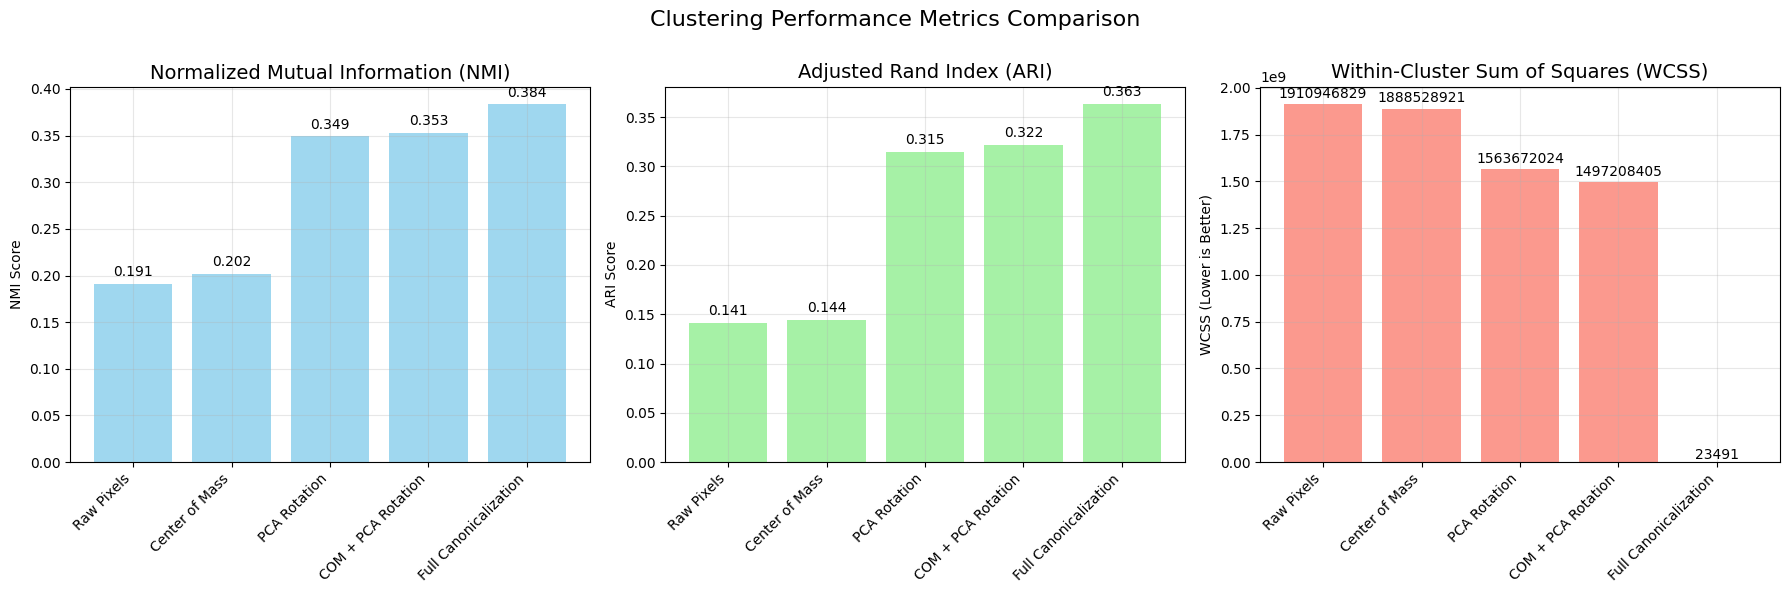

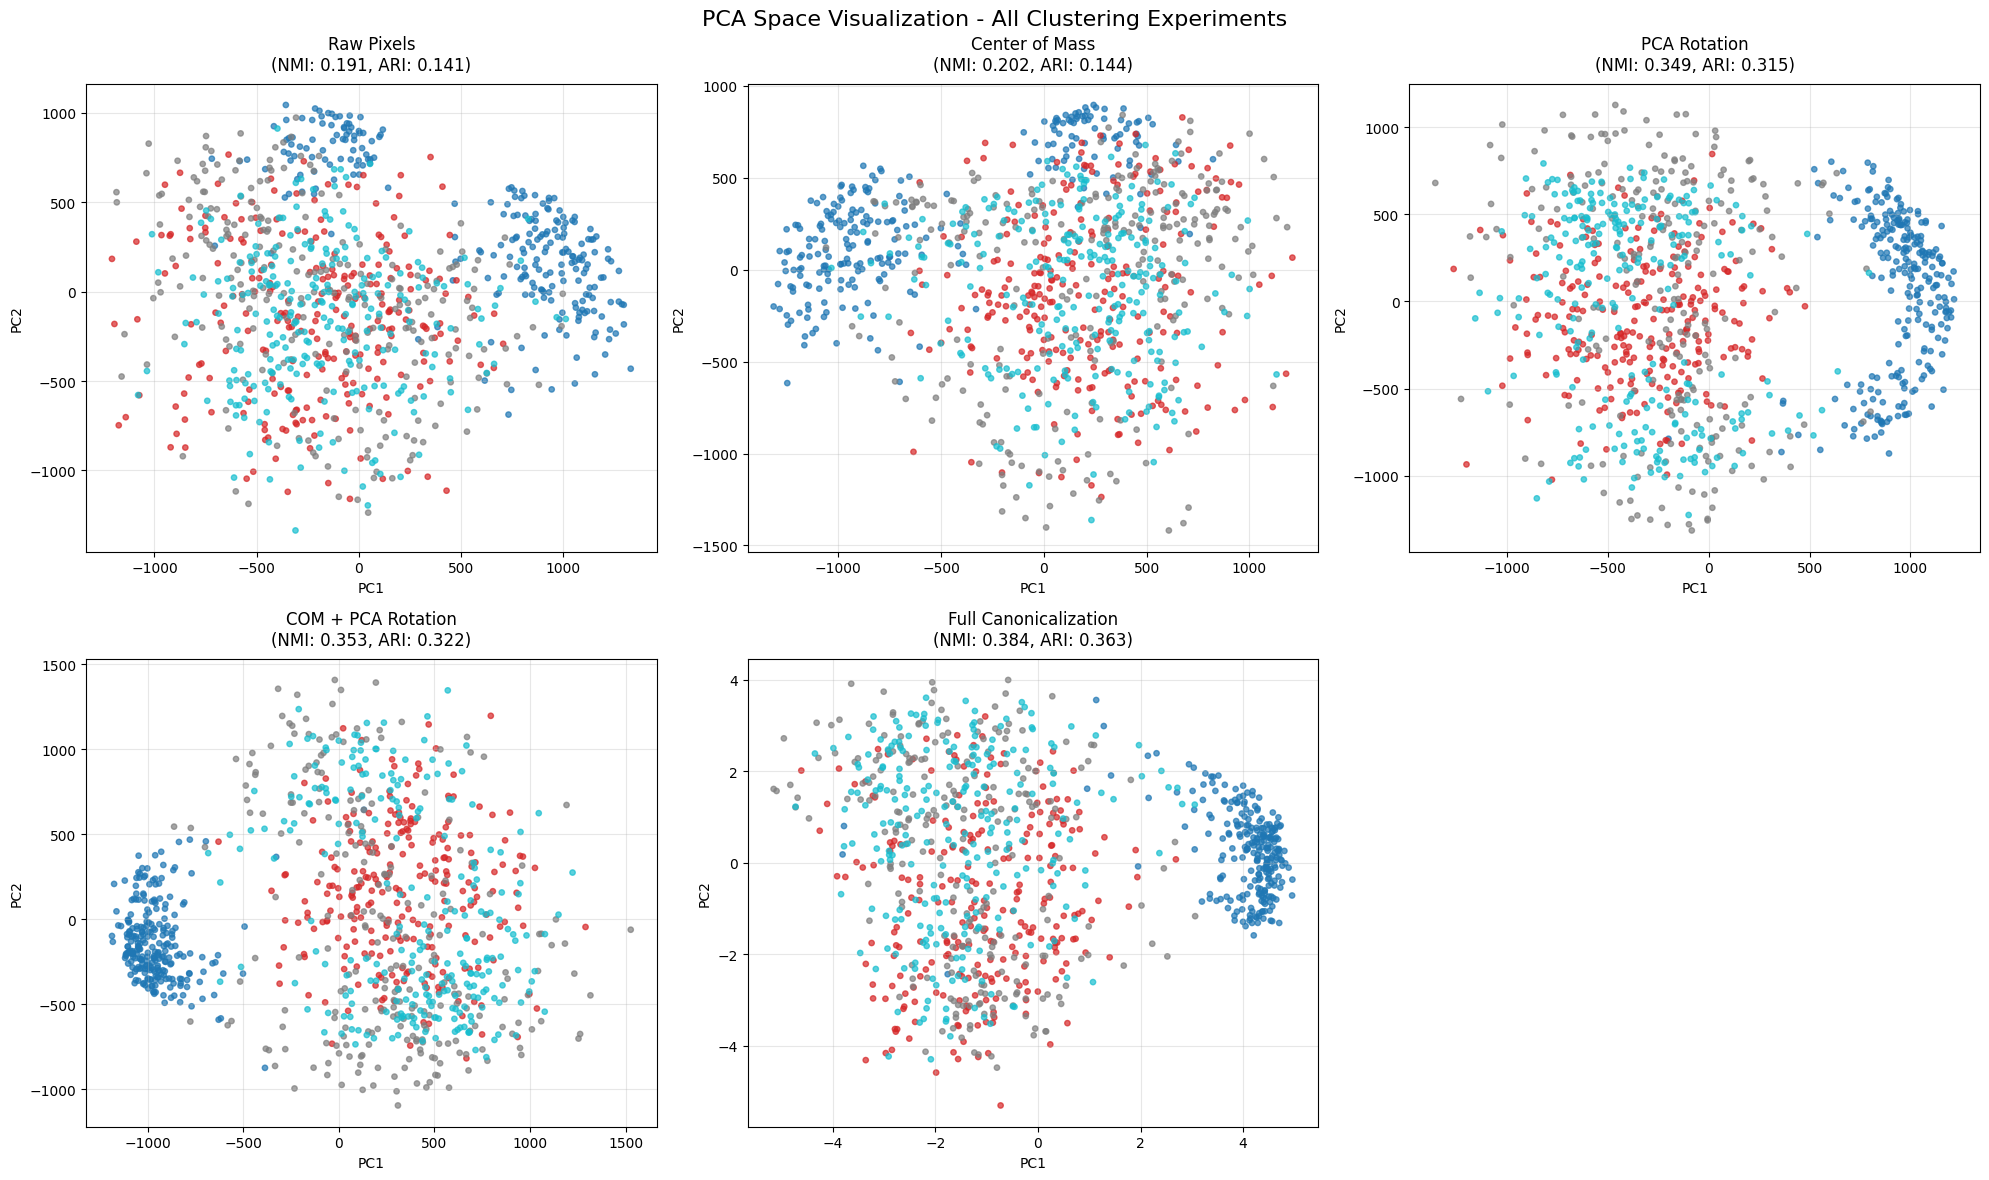

In [88]:
experiment_runner = ClusteringExperimentRunner(X, y)
results = experiment_runner.run_all_experiments()
results_df = experiment_runner.display_results_table()
experiment_runner.plot_metrics_comparison()
experiment_runner.plot_pca_comparison()